On va avoir plusieurs classes. Des petits bonhommes dnas un monde. La classe monde contient un attribut people.
Comment les acteurs vont interagir entre eux ? 
Qui fait bouger les gens, le monde où Dieu ? 
Une fois que la structure de base est faite, on peut implenter des comportements de plsu en plsu compliqués

In [127]:
import numpy as np
import time
import matplotlib.pyplot as plt 

## Class AllocationSolver

In [118]:
import numpy as np

def pos_to_id(pos):
    """
        Transfrom a position to a unique key for a dictionary
    """
    res = ""
    for x in pos:
        res += '_' + str(x)
    return(res)    


def fight_method_default(id_perss, perss):
    """
        This is the default method of fighting
        Just pick a random person from the fighters.
        This does not use any characteristec (so no use of perss)
        Later the aim would be to use special characteristic to select the winner
    """
    i = np.random.randint(0,len(id_perss))
    return id_perss[i]


def fight_method_angry(id_perss, perss):
    """
        This is an advanced fight method
        This use the angryness atribut of people to determine which one will win
    """
    max_level = None
    for id_pers in id_perss:
        p_level = perss[id_pers].angryness # Level of angryness of "id_pers"
        
        if max_level is None or max_level < p_level: #Strictly better
            max_level, angry_peoples = p_level, [id_pers]
        elif max_level == p_level: #Same level
            angry_peoples.append(id_pers)
            
    # Picking a random one from the most angry
    i = np.random.randint(0,len(angry_peoples))
    return angry_peoples[i]
            
        
    

    
class AllocationSolver:
    """
        Manage all the allocation and find the one matching all requirement.
    """

    def __init__(self, fight_method = None):
        """
            Init method to store parameters
        """
        
        # Function of selection for a position
        self.fight_method =  fight_method_default if fight_method is None else fight_method
        
        
#
#  Interface function
#
    def solve(self, perss):
        """
            Solve the alocation problem for all person (class People) in "perss" 
        """
        self.perss = perss # People to allocate
        
        self.set_param() # Initiate the variable "wills" and "now"
        
        self.war() # Handle conflict of wills

        # Move everyone if possible (handles cycle)
        for pos in self.now:
            self.move(pos) # Recursive function
            
        return self.wills, self.now # Solution of the problem

    
#
#  Solving function
#   

    def set_param(self):
        """
            Recupere tous les voeux et les positions actuels.
            Chaque individu est identifié par son index dans ce tableau (qui est unique)
        """
        self.now, self.wills = [], []
        for p in self.perss:
            self.now.append(p.pos)
            self.wills.append(p.get_will())  
        return self
    
    
    def war(self):
        """
            Réalise tout les combats et répertorie qui a droit de changer de place ou nom
        """
        # Store all the conflict
        fights = self.get_same_wills() 
        
        # Solve each conflict one by one with the method "fight_method"
        for id_pos, id_perss in fights.items():
            
            # On execute le combat et on récupère l'id du gagnant
            one = self.fight_method(id_perss, self.perss)
            
            # On met tous les voeux des refusés à None ce qui revient à refuser son voeu
            for id_pers in id_perss:
                if id_pers != one: self.wills[id_pers] = None
                    
        return self


    def move(self, pos, moving = None):
        """
            Move regarde si la place ou la personne veut aller est libre
                et sinon si la personne qui y est veut bouger. 
            Comme les combats ont été gérés on sait qu'il n'y a
                plus de combats pour prendre la place. 
            Si la personne peut prendre la place, move répond True et modifie now.         
        """
        now, wills = self.now, self.wills #Shortcut
        pos = list(pos)
        
        moving = [] if moving is None else moving # Handle issue with pointer if "moving = []"
        if pos in now:
            p_id = now.index(pos) # Personne sur la case
            will = wills[p_id] # Voeux de la personne

            if will == pos or will is None: # Il souhaite ne pas bouger
                return False

            if p_id in moving: # Gère le cas de la boucle 
                now[p_id] = will
                return True

            else: # Il veut aller quelque part
                moving.append(p_id)
                is_empty = self.move(will, moving) # On essaie de vider la case voulue
                if (is_empty):
                    now[p_id] = will
                    return True
                else:
                    return False

        else:     # Il n'y a personne et la position est dans le monde 
            return True
    
    
    
#
#  Utilities
#
       
    def get_same_wills(self):
        """
            Répertorie dans un dictionnaire toutes les positions demandees et qui les demande
        """
        d = {}
        
        for id_pers, pos in enumerate(self.wills):
            # On transforme la position en une clé pour le dictionnaire
            id_pos = pos_to_id(pos)
            
            if id_pos in d:
                # Ajoute la personne à la liste des personnes ayant le voeu "will" dont la clé est "id_pos"
                d[id_pos].append(id_pers)
           
            else:
                # Pour une position nouvelle, crée la nouvelle clé dans le dictionnaire d 
                d[id_pos] = [id_pers] 
        
        return d

# Class World 

In [183]:

class World1D(object):
    """
        Put limits, collect all variables and make them interact 
    """
    def __init__(self, l, allocator = None):
        self.l = l                       # Définir la taille du monde 
        self.peoples = []                # Tableau dans lequel on stockera tout les individus qui évoluent dans le monde 
        self.peoples_out = []            # Tableau dans lequel on stockera tout les individus qui sont sortis du monde 
        self.pos_out = [l-1]             # Position de la sortie 
        
        self.allocator = AllocationSolver() if allocator is None else allocator
        
        
    def add_people(self, p):
        """
            Add peoples to the list of peoples that are in the World
        """
        self.peoples.append(p)
 


#
# Main function 
#
    
    def live_round(self):
        """
            Give its new position to every individuals, put out individual that take the exit 
        """
        
        # Alloue les nouvelles positions 
        wills, now = self.allocator.solve(self.peoples)
        
        # Donne à chaque individus sa nouvelle position 
        for i, p in enumerate(self.peoples):
            p.set_pos(now[i])
        
        # Sort celui qui est sur la porte (ou ceux au premier tour) 
        self.expulse()
        
        
        
    def expulse(self):
        """
            Under the pos_in condition, put someone out of the world by deleting him from people and pu
        """
        for i, p in enumerate(self.peoples):
            if p.pos == self.pos_out:
                self.peoples_out.append(p)
                del self.peoples[i]
                  
    
    def pos_in(self, pos):
        """
            Check that the position is inside the World 
        """
        if pos == self.pos_out :
            return True 
        else :
            return pos[0] < self.l and 0 <= pos[0] 

              
    
    
#
# Running and diplaying    
#
    
    def show(self):
        """
            Handle the displaying in 1D, ____X___ where X is the logo of a people
        """
        res = ["_"] * self.l #chaîne caractère, ie liste de caractère séparées 
        for p in self.peoples:
            res[int(p.pos[0])] = p.logo
        print("".join(res), end="\r") # join permet de coller les caractères 

    
    def animate(self, T):
        """
            Display in 1D, makes all run 
        """
        self.show()
        for t in range(T):
            time.sleep(0.1)
            self.live_round()
            self.show()
            
            
    def simulate(self):
        """
            Run everything without diplaying 
        """
        start_time = time.time()
        while len(self.peoples) != 0 :
            self.live_round()
        elapse_time = time.time() - start_time
        return elapse_time

            
    
#
# Passage en 2D 
#
 
    
class World2D(World1D):
    """ 
        Transition towards multiple dimension
    """
    
    def __init__(self, l, allocator = None):
        super(World2D, self).__init__(l, allocator)
        self.pos_out = [0,0]
            
            
    def pos_in(self, pos):
        return (np.absolute(pos) < self.l).all() and pos != self.pos_out
    
    

# Class People

In [173]:
class People(object):
    def __init__(self, pos, world, logo = "X", speed = 1):
        """
            Création of individuals with them caractéristics
        """
        self.pos = pos
        self.logo = logo
        self.speed = speed
        self.world = world
        world.add_people(self)
        
        # Stats
        self.angryness = 0
        self.path = [self.pos]
                 
            
    def get_will(self): # L'individu demande à prendre sa position suivante, le monde va gérer qui gagne les combats
        direction = np.array(self.world.pos_out) - np.array(self.pos)
        pas_pur = np.linalg.norm(direction)
        fac = min(self.speed,pas_pur)
        pas = (direction/pas_pur) * fac
        return list(np.round(np.array(self.pos) + pas))
    
    
    def set_pos(self, pos):
        if self.pos == pos:
            self.angryness += 1
        self.pos = pos
        self.path.append(pos) # on ajoute au tableau data, la nouvelle position de l'individu

[[2],
 [4.0],
 [6.0],
 [8.0],
 [10.0],
 [12.0],
 [14.0],
 [16.0],
 [18.0],
 [20.0],
 [22.0]]

In [175]:
# Test 
# Pour avoir des stats 
# Renvoie un graphique des positions successives prises par un individu     
# Pour que ça marche, mettre un path de peoples 


In [187]:
w = World2D(20)
for i in range(200):
    People(pos = list(np.random.randint(-19,19,(1,2))[0]), world = w, speed = 1)

w.simulate()

0.7936739921569824

<IPython.core.display.Javascript object>


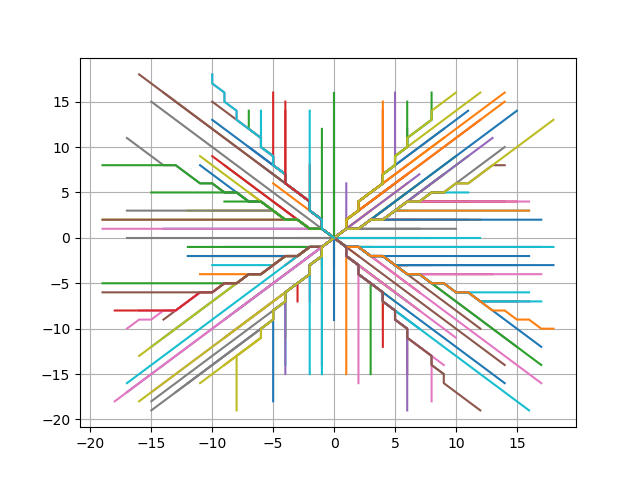

In [188]:
plt.figure()
plt.grid(True)
for p in w.peoples_out:
    x = np.array(p.path)
    plt.plot(x[:,0], x[:, 1])

<IPython.core.display.Javascript object>


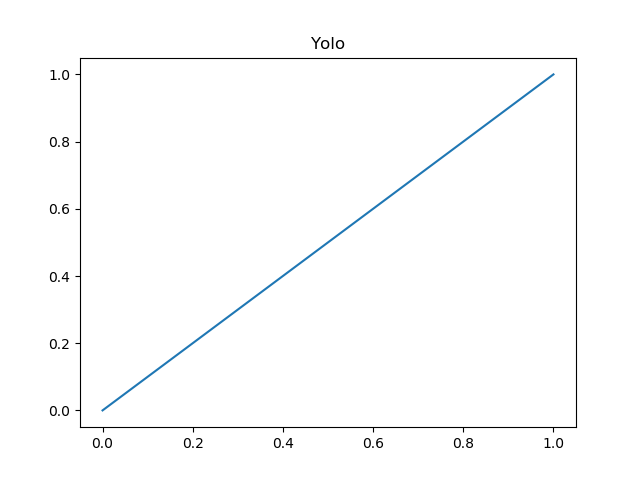

In [135]:
plt.figure()
plt.title("Yolo")
plt.plot([0,1], [0,1])

# Affichage 2D

In [124]:
%matplotlib notebook

<IPython.core.display.Javascript object>


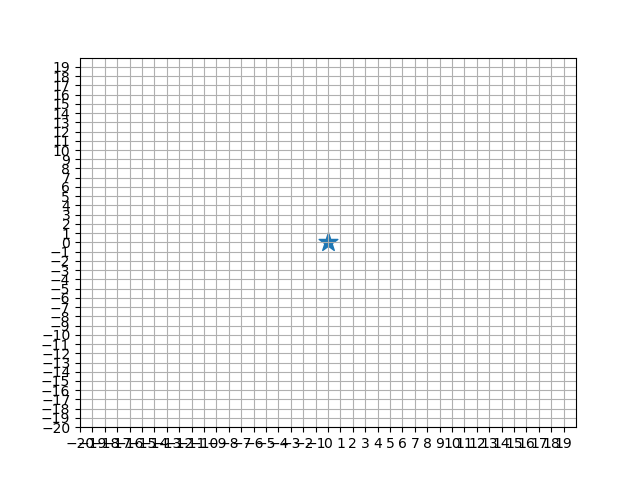

In [126]:
import matplotlib.animation as animation

w = World2D(20)
for i in range(30):
    People(pos = list(np.random.randint(-19,19,(1,2))[0]), world = w, speed = 1)


#
# Affichage 2D 
#

    
fig, ax = plt.subplots()
def animate(i):
    w.live_round()
    ax.clear()
    plt.grid(True)
    plt.xticks(range(-w.l, w.l))
    plt.yticks(range(-w.l, w.l))
    plt.xlim(-w.l, w.l)
    plt.ylim(-w.l, w.l)
    ax.scatter(w.pos_out[0], w.pos_out[1], marker="*", s=200)
    for p in w.peoples:
        ax.scatter(p.pos[0], p.pos[1], marker="x", s = 100)

ani = animation.FuncAnimation(fig, animate, [0,1], interval=500)
plt.show()    

In [104]:
w.peoples_out[0].path

IndexError: list index out of range

In [ ]:
a = np.array([2,1])
b = np.array([10,40])

c = b - a
c = c/np.linalg.norm(c)
np.round(c), c

In [ ]:
jeanne.angryness

In [ ]:
%matplotlib notebook

# Backup

In [ ]:
# Version précédente

    def get_wills(self):
        d = {}
        for i, p in enumerate(self.peoples):
            pos = p.ask_pos()
            id_pos = pos_to_id(pos)
            if id_pos in d:
                d[id_pos].append(p)
            else:
                d[id_pos] = [p]
        return d 
        
        for pos, ps in d.items():
            pass
            

In [ ]:

            
        
    def live(self):
        for i, p in enumerate(self.peoples):
            pos = p.ask_pos()
            if (not(self.pos_in(pos))):
                del self.peoples[i]
                self.peoples_out.append(p)
            p.pos = pos # pour l'instant, on accèpte toutes les positions demandées par les peoples
            p.data.append(pos)
            #pos = w.given_pos(self)
            
    
    
    def asked_pos(self):
        asked_pos = []
        for p in self.peoples:
            asked_pos.append(p.ask_pos())
        return asked_pos
            
    
    def distinct(self):
        a_p = self.asked_pos() 
        n = len(a_p)
        flag = True
        #id_ap = []
        for i in range (0,n): 
            for j in range (i,n-1):
                if a_p[i] == a_p[j]:
                    flag = False                                                    
        #           id_ap.append([i,j])
        #if id_ap == []:
        #    return True
        #else: 
        #    return id_ap
        return flag
            
            
    def given_pos(self): 
        for p in self.peoples:
            if self.distinct():
                p.pos = p.ask_pos()
            else :
                p.pos = p.ask_pos() # pour l'instant 
            #    p.pos = colision.rfight(self)
        #return p.pos
                
            
            
    def animate(self, T):
        self.show()
        for t in range(T):
            time.sleep(0.5)
            self.live()
            self.show()
        
        

                  
    

Interdire à une personne de changer sa pos tout seul
Le Dieu dans le monde pour ne pas avoir à récupéprer qui est dedans et qui ne l'est pas. 


In [ ]:
"_".join([0,])

In [ ]:
#La classe colision doit permettre de décider ce qu'il se pase en cas de collision 

class Colision:
    def __init__(p1, p2):
        p1.self = p1  # p1 est une personne de la classe People
        p2.self = p2  # idem p2
    
    def homme_femme_enfant(self):
        if p1.sexe != p2.sexe :
            s1 = p1.sexe 
            s2 = p2.sexe
            if s1 == "F" or s1 == "M" and s2 == "E":
                p2.pos = p2.next_pos # à modifier au regard de comment est écrite world.live
            if s1 == "M" and s2 == "F":
                p2.pos = p2.next_pos # à modifier au regard de comment est écrite world.live
            if s2 == "F" or s2 == "M" and s1 == "E":
                p1.pos = p1.next_pos # à modifier au regard de comment est écrite world.live
            if s2 == "M" and s1 == "F":
                p1.pos = p1.next_pos # à modifier au regard de comment est écrite world.live
                
                

Gérer les colisions
On peut faire une classe arène qui va gérer les colisions 
Ou dans la classe personne, une classe fight 
Chaque personne s'énerve au fur et à mesure qu'on lui refuse d'avancer.
Un fou le devient quand on a refuser qu'il avance
    Alors, il tue tout le monde et va vite

In [ ]:
w = World(l = 20)
People([0], w)
People([0], w)
People([2], w)
People([3], w)

peoples = w.peoples

In [ ]:
d = {}
pos_taken = []
for i, p in enumerate(peoples):
    pos_taken.append(p.pos)
    pos_asked = p.ask_pos()
    id_pos = pos_to_str(pos_asked)
    if id_pos in d:
        d[id_pos].append(p)
    else:
        d[id_pos] = [p]
d, pos_taken

In [ ]:
for id_pos in d.keys():
    

In [ ]:
def pos_to_str(pos):
    return "_".join(str(x) for x in pos)

In [ ]:
pos_to_str(["0","1"])